# 2-Dimensional Frame Analysis
This program performs an elastic analysis of 2-dimensional structural frames.  It has the following features:
1. Input is provided by a set of 7 CSV files (and cell-magics exist so you can specifiy the CSV data
in a notebook cell).  See ethe example at the botton for an, er, example.
1. Handles concentrated forces on nodes, and concentrated forces, concentrated moments, and linearly varying distributed loads applied transversely anywhere along the member (i.e., there is no way to handle parallel
load components).
1. It handles fixed, pinned, roller supports and member end moment releases (internal pins).  The former are
handled by assigning free or fixed global degrees of freedom, and the latter are handled by adjusting the 
member stiffness matrix.
1. The DOF #'s are assigned by the program, with the fixed DOF #'s assigned after the non-fixed.  The equilibrium
equation is then partitioned for solution.  Among other advantages, this means that support settlement could be
easily added (there is no UI for that, yet).
1. A non-linear analysis can be performed using the P-Delta method (fake shears are computed at column ends due to the vertical load acting through horizontal displacement differences, and these shears are applied as extra loads
to the nodes).
1. A full non-linear (2nd order) elastic analysis will soon be available by forming the equilibrium equations 
on the deformed structure.  This is very easy to add, but it hasn't been done yet.  Shouldn't be too long.
1. There is almost no documentation below, but that will change, slowly.

In [1]:
from __future__ import division, print_function   # get ready for Python 3

In [2]:
DEBUG = __name__ == '__main__'

In [3]:
from IPython.core.magic import register_line_cell_magic, register_cell_magic
from io import StringIO
import pandas as pd
import numpy as np
from collections import OrderedDict, defaultdict
import inspect
import os, os.path
import math    
import time
from salib import showImage

In [4]:
try:
    inspect.signature   # if this exists, then we are using Python 3.0
    import collections
    def getArgSpec(fn):
        """Simulate inpect.getargspec from Python 2.7 for Python 3.0, because the
        inpect module thats been backported to 2.7 isn't easily or automatically
        available in 2.7.  So we forward port old getargspec to 3.0 to circumvent
        the deprecation warning messages at run time."""
        sig = inspect.signature(fn)
        aspec = collections.namedtuple('ArgSpec','args,varargs,keywords,defaults')
        args = [k for k,p in sig.parameters.items() if p.kind == inspect.Parameter.POSITIONAL_OR_KEYWORD]
        va = [k for k,p in sig.parameters.items() if p.kind == inspect.Parameter.VAR_POSITIONAL]
        varargs = va[0] if len(va) >= 1 else None
        kw =[k for k,p in sig.parameters.items() if p.kind == inspect.Parameter.VAR_KEYWORD]
        keywords = kw[0] if len(kw) >= 1 else None
        defaults = [p.default for k,p in sig.parameters.items() if p.default != inspect._empty]
        return aspec(args,varargs,keywords,defaults)
except:
    getArgSpec = inspect.getargspec  # use the one from 2.7 as is

If the SST module is loadable, member properties may be specified by giving steel shape designations
(such as 'W310x97') in the member properties data.  If the module is not available, you may still give $A$ and
$I_x$ directly (it only tries to lookup the properties if these two are not provided).

In [5]:
try:
    from sst import SST
    __SST = SST()
    get_section = __SST.section
except ImportError:
    def get_section(dsg,fields):
        raise Exception('Member property SIZE lookup not available because SST not importable.  SIZE = {}'.format(dsg))
        return [1.] * len(fields.split(',')) # in case you want to do it that way

## Utilities

In [6]:
np.set_printoptions(linewidth=200,precision=6,suppress=True)
import contextlib
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

In [7]:
def pv(v,units=None,precision=None,minval=1E-15,label=None,ioffset=0):
    """Print a column vector of values, 'v', with each value labelled
    with its row index.  Option 'units' is a sequence of scales, where
    each scale is either a number, or a 2-tuple of (number,unit_name).
    The value is divided by the number, and the unit_name is displayed
    after (if given).  If the units sequence is shorter than then 
    vector, items are repeated (cycled) 'precision' is the number of 
    digits to the right of the decimal point, and defaults to the 
    global numpy setting."""
    nr,nc = v.shape
    assert nc == 1, 'v must have exactly 1 column. It has ' + str(nc)
    if precision is None:
        precision = np.get_printoptions()['precision']
    sv = [''] * nr
    uv = [''] * nr
    for i in range(nr):
        val = v[i,0]
        if units is not None:
            u = units[i%len(units)]
            try:
                val *= u[0]
                uv[i] = ' '+u[1]
            except:
                val *= u
        if minval and abs(val) < abs(minval):
            sv[i] = '0.' + (('0' + ' '*(precision-1)) if precision > 0 else '')
        else:
            sv[i] = '{0:.{1}f}'.format(val,precision)
    vwid = max([len(s) for s in sv])
    if label is not None:
        print('-'*(vwid+3+1+2) + ' ' + str(label) + ':')
    for i in range(nr):
        print('{0:3d}:  {1:>{2}s}{3}'.format(i+ioffset,sv[i],vwid,uv[i]))


In [8]:
def prhead(txt,ul='='):
    """Print a heading and underline it."""
    print()
    print(txt)
    if ul:
        print(ul*(len(txt)//len(ul)))
    print()

In [9]:
@register_line_cell_magic
def csv_load(line,cell):
    s = StringIO(cell)
    data = pd.read_csv(s,skipinitialspace=True,error_bad_lines=False,warn_bad_lines=True)
    line = line.strip()
    if not line:
        return data
    words = line.split()
    var = words[0]
    g = get_ipython().user_global_ns
    g[var] = data
    ##data.to_csv(var+'.csv',index=False)

In [10]:
import re
@register_cell_magic
def frame_data(line,cell):
    """Usage:  %%frame_data framevar tablename
    The value of global variable 'framevar' must be an instance of class Frame2D.
    'tablename' must be the name of one of the seven data (CSV) files that define
    the structure.  Following this in the cell is the CSV data for that table."""
    mo = re.match(r'\s*(\S+)\s+(\S+)\s*$',line)
    if not mo:
        raise Exception('Usage: %%frame_data framevar tablename')
    framevar,tablename = mo.groups()
    
    globns = get_ipython().user_global_ns
    if framevar in globns:
        if not isinstance(globns[framevar],Frame2D):
            raise Exception('The value of "{}" is not a Frame2D object.'.format(framevar))
    else:
        raise Exception('The value of "{}" is not defined.  It should be an instance of "Frame2d"'.format(framevar)) # ???
        globns[framevar] = Frame2D()
        
    frame = globns[framevar]
    pfx = 'install_'
    installer = getattr(frame,pfx+tablename,None)
    if not callable(installer):
        l = [t[len(pfx):] for t in dir(frame) if t.startswith(pfx) and callable(getattr(frame,t,None))]
        l.sort()
        raise Exception('Table name "{}" is invalid: Must be one of: {}'.format(tablename,', '.join(l)))
    s = StringIO(cell)
    data = pd.read_csv(s,skipinitialspace=True,error_bad_lines=False,warn_bad_lines=True)
    if not data.empty:
        installer(data)

In [11]:
def isnan(x):
    if x is None:
        return True
    try:
        return np.isnan(x)
    except TypeError:
        return False

## class Node

In [12]:
class Node(object):
    
    DIRECTIONS = {'FX':0, 'FY':1, 'MZ':2}
    
    def __init__(self,ident,x,y):
        self.id = ident
        self.x = x
        self.y = y
        self.constraints = set()
        self.dofnums = [None] * 3
        
    def add_constraint(self,cname):
        c = cname.upper()
        if c not in self.DIRECTIONS:
            raise Exception('Invalid constraint name: {}'.format(cname))
        self.constraints.add(c)
        
    def to(self,other):
        """Return the directional cosines and distance to the other node."""
        dx = other.x-self.x
        dy = other.y-self.y
        L = math.sqrt(dx*dx + dy*dy)
        return dx/L,dy/L,L
        
    def __repr__(self):
        return '{}("{}",{},{})'.format(self.__class__.__name__,self.id,self.x,self.y)

## class Member

In [13]:
class Member(object):
    
    RELEASES = {'MZJ':2, 'MZK':5}
    
    E = 200000.
    G = 77000.
    
    def __init__(self,ident,nodej,nodek):
        self.id = ident
        self.nodej = nodej
        self.nodek = nodek
        self.dcx,self.dcy,self.L = nodej.to(nodek)
        self.KL = None           # stiffness matrix, local coords
        self.KG = None           # stiffness matrix, global coords
        self.releases = set()
        self.Ix = None
        self.A = None
        self.Tm = None           # transformation matrix, global to local
        self.fefsl = None        # fixed end forces, local coordinates
        self.mefs = None         # member end forces, local coordinates
        
    def add_release(self,rel):
        r = rel.upper()
        if r not in self.RELEASES:
            raise Exception('Invalid release name: {}'.format(rel))
        self.releases.add(r)
        
    def __repr__(self):
        return '{}("{}","{}","{}")'.format(self.__class__.__name__,self.id,self.nodej,self.nodek)
    
    def localK(self):
        """Return the member stiffness matrix in local coordinates"""
        L = self.L
        E = self.E
        A = self.A
        I = self.Ix
        k0 = E*A/L
        k12 = 12.*E*I/L**3
        k6 = 6.*E*I/L**2
        k4 = 4.*E*I/L
        k2 = 2.*E*I/L
        KL = np.mat([[ k0,  0,    0,   -k0,   0,    0],
                     [ 0,   k12,  k6,   0,   -k12,  k6],
                     [ 0,   k6,   k4,   0,   -k6,   k2],
                     [-k0,  0,    0,    k0,   0,    0],
                     [ 0,  -k12, -k6,   0,    k12, -k6],
                     [ 0,   k6,   k2,   0,   -k6,   k4]])
        for r in self.releases:
            KL = self.releaseK(KL,self.RELEASES[r])
        self.Kl = KL
        return KL
            
    def releaseK(self,Kl,rel):
        """Return a modified stiffness matrix to account for a moment release
        at one of the ends.  Kl is the original matrix, dx, dy are projections of the
        member, and 'rel' is 2 or 5 to identify the local dof # of the released dof.
        Both KL and KG are returned if the transformation matrix, T, is provided"""
        L = self.L
        if rel == 2:
            if Kl[5,5] == 0.:   # is other end also pinned?
                em = np.mat([1.,0.]).T    # corrective end moments, far end pinned
            else:
                em = np.mat([1.,0.5]).T   # corrective end moments, far end fixed
        elif rel == 5:
            if Kl[2,2] == 0.:
                em = np.mat([0.,1.]).T
            else:
                em = np.mat([0.5,1.]).T
        else:
            raise ValueError("Invalid release #: {}".format(rel))
        Tf = np.mat([[0.,0.],[1./L,1./L],[1.,0.],[0.,0.],[-1./L,-1./L],[0.,1.]])
        M = Tf*em

        K = Kl.copy()    
        K[:,1] -= M*K[rel,1]  # col 1 - forces for unit vertical displacment at j-end
        K[:,2] -= M*K[rel,2]  # col 2 - forces for unit rotation at j-end
        K[:,4] -= M*K[rel,4]  # col 4 - forces for unit vertical displacment at k-end
        K[:,5] -= M*K[rel,5]  # col 5 - forces for unit rotation at k-end
        return K

    def transform(self):
        """Return a transformation matrix to transform forces and displacements
        in global coordinates to local coordinates for the 2-d frame member.
        This is called the member transformation matrix, Tm"""
        cx = self.dcx
        cy = self.dcy
        self.Tm = np.mat([[ cx,  cy,  0,   0,   0,   0],
                          [-cy,  cx,  0,   0,   0,   0],
                          [ 0,   0,   1,   0,   0,   0],
                          [ 0,   0,   0,   cx,  cy,  0],
                          [ 0,   0,   0,  -cy,  cx,  0],
                          [ 0,   0,   0,   0,   0,   1]])
        return self.Tm
    
    def fefs(self,loads):
        if loads:
            fef = loads[0].fefs()
            for load in loads[1:]:
                fef += load.fefs()
            for r in self.releases:
                fef = self.releaseFEF(fef,self.RELEASES[r])
        else:
            fef = zerofefs()
        self.fefsl = fef            
        return fef
    
    def vm(self,loads,mefs=None):
        """Return shear and moment 'diagrams'.  Return (xv,v,xm,m) -
        xv and xm are positions along span, and v and m are shears and
        moments at those points.  Use normal sign convention (not beam sign 
        convention) - on left FBD, moments +ive CCW, shear +ive upwards.
        """
        def _getx(self,loads,attr):
            degree = 0
            pts = [0.,self.L]
            for load in loads:
                pt1,pt2,d = getattr(load,attr)
                for p in pt1,pt2:
                    if p is not None:
                        pts.append(p)
                if d > degree:
                    degree = d
            ptsv = np.array(pts)
            if degree > 1:
                ptsv = np.concatenate((ptsv,np.linspace(0,self.L)))
            ptsv.sort()
            return np.unique(ptsv)
        
        xv = _getx(self,loads,'vpts')
        xm = _getx(self,loads,'mpts')
        return xv,None,xm,None
    
    def releaseFEF(self,fef,rel):
        """Return a modified fixed end force vector to account for a moment release
        at one of the ends.  fef is the original matrix, 'rel' is 2 or 5 to identify 
        the local dof # of the released moment."""
        L = self.L
        if rel == 2:
            if fef[5,0] == 0.:   # is other end also pinned?
                em = np.mat([1.,0.]).T    # corrective end moments, far end pinned
            else:
                em = np.mat([1.,0.5]).T   # corrective end moments, far end fixed
        elif rel == 5:
            if fef[2,0] == 0.:
                em = np.mat([0.,1.]).T
            else:
                em = np.mat([0.5,1.]).T
        else:
            raise ValueError("Invalid release #: {}".format(rel))
        Tf = np.mat([[0.,0.],[1./L,1./L],[1.,0.],[0.,0.],[-1./L,-1./L],[0.,1.]])
        M = Tf*em

        return fef - M*fef[rel,0]


## Classes for Applied Loads

In [14]:
class Load(object):
    
    EPSILON = 1.0E-6
    
    @classmethod
    def all_subclasses(cls):
        all_subclasses = []
    
        for subclass in cls.__subclasses__():
            all_subclasses.append(subclass)
            all_subclasses.extend(subclass.all_subclasses())

        return all_subclasses

    @classmethod
    def subclass(cls,ltype,L,data):
        classes = cls.all_subclasses()
        for c in classes:
            if c.__name__ == ltype:
                aspec = getArgSpec(c.__init__)
                args = aspec.args[2:]
                defaults = aspec.defaults or ()
                argl = zip(args,(None,)*(len(args)-len(defaults)) + defaults)
                argv = {}
                for k,v in argl:
                    if k in data and not isnan(data[k]) and data[k] is not None:
                        argv[k] = data[k]
                    elif v is not None:
                        argv[k] = v
                ##print c,args,argl,'argv =',argv
                return c(L,**argv)
        raise Exception('Invalid load type: {}'.format(ltype))
        
    def fefs(self):
        """Return the complete set of 6 fixed end forces produced by the load."""
        raise NotImplementedError()
        
    def shear(self,x):
        """Return the shear force that is in equilibrium with that
        produced by the portion of the load to the left of the point at 
        distance 'x'.  'x' may be a scalar or a 1-diemnsiional array
        of values."""
        raise NotImplementedError()
        
    def moment(self,x):
        """Return the bending moment that is in equilibrium with that
        produced by the portion of the load to the left of the point at 
        distance 'x'.  'x' may be a scalar or a 1-diemnsiional array
        of values."""
        raise NotImplementedError()
        
def zerofef():
    return np.mat(np.zeros((6,1)))

def makefef(l):
    return np.mat(np.array(l).reshape((6,1)))

class UDL(Load):
    
    def __init__(self,L,W1):
        self.L = L
        self.W = W1
        
    def __repr__(self):
        return '{}(L={},W1={})'.format(self.__class__.__name__,self.L,self.W)
    
    def fefs(self):
        L = self.L
        w = self.W
        return makefef([0.,-w*L/2., -w*L*L/12., 0., -w*L/2., w*L*L/12.])
    
    def shear(self,x):
        l = x*(x>0.)*(x<=self.L) + self.L*(x>self.L)    # length of loaded portion
        return -(l*self.W)
    
    def moment(self,x):
        l = x*(x>0.)*(x<=self.L) + self.L*(x>self.L)   # length of loaded portion
        d = (x-self.L)*(x>self.L)   # distance from loaded portion to x: 0 if x <= L else x-L
        return self.W*l*(l/2.+d)
    
    @property
    def vpts(self):
        return (0.,self.L,1)
    
    @property
    def mpts(self):
        return (0.,self.L,2)
        
class LVL(Load):
    
    def __init__(self,L,W1,W2=None,A=None,B=None,C=None):
        if A is not None and B is not None and C is not None and L != (A+B+C):
            raise Exception('Cannot specify all of A, B & C')
        if A is None:
            if B is not None and C is not None:
                A = L - (B+C)
            else:
                A = 0.
        if C is None:
            if B is not None:
                C = L - (A+B)
            else:
                C = 0.
        if B is None:
            B = L - (A+C)
        if W2 is None:
            W2 = W1
        self.L = L
        self.W1 = W1
        self.W2 = W2
        self.A = A
        self.B = B
        self.C = C
        
    def fefs(self):
        """This mess was generated via sympy.  See:
        ../../examples/cive3203-notebooks/FEM-2-Partial-lvl.ipynb """
        L = float(self.L)
        a = self.A
        b = self.B
        c = self.C
        w1 = self.W1
        w2 = self.W2
        m2 = -b*(15*a*b**2*w1 + 5*a*b**2*w2 + 40*a*b*c*w1 + 20*a*b*c*w2 + 30*a*c**2*w1 + 30*a*c**2*w2 + 3*b**3*w1 + 2*b**3*w2 + 10*b**2*c*w1 + 10*b**2*c*w2 + 10*b*c**2*w1 + 20*b*c**2*w2)/(60.*(a + b + c)**2)
        m5 = b*(20*a**2*b*w1 + 10*a**2*b*w2 + 30*a**2*c*w1 + 30*a**2*c*w2 + 10*a*b**2*w1 + 10*a*b**2*w2 + 20*a*b*c*w1 + 40*a*b*c*w2 + 2*b**3*w1 + 3*b**3*w2 + 5*b**2*c*w1 + 15*b**2*c*w2)/(60.*(a + b + c)**2)
        v4 = -(b*w1*(a + b/2.) + b*(a + 2*b/3.)*(-w1 + w2)/2. + m2 + m5)/L
        v1 = -b*(w1 + w2)/2. - v4
        return makefef([0.,v1,m2,0.,v4,m5])
    
    def __repr__(self):
        return '{}(L={},W1={},W2={},A={},B={},C={})'\
               .format(self.__class__.__name__,self.L,self.W1,self.W2,self.A,self.B,self.C)
        
    def shear(self,x):
        c = (x>self.A+self.B)    # 1 if x > A+B else 0
        l = (x-self.A)*(x>self.A)*(1.-c) + self.B*c  # length of load portion to the left of x
        return -(self.W1 + (self.W2-self.W1)*(l/self.B)/2.)*l        
        
    def moment(self,x):
        c = (x>self.A+self.B)    # 1 if x > A+B else 0
        #           note: ~c doesn't work if x is scalar, thus we use 1-c
        l = (x-self.A)*(x>self.A)*(1.-c) + self.B*c  # length of load portion to the left of x
        d = (x-(self.A+self.B))*c                  # distance from right end of load portion to x
        return ((self.W1*(d+l/2.)) + (self.W2-self.W1)*(l/self.B)*(d+l/3.)/2.)*l
    
    @property
    def vpts(self):
        return (self.A,self.A+self.B,1 if self.w1==self.w2 else 2)
    
    @property
    def mpts(self):
        return (self.A,self.A+self.B,2 if self.w1==self.w2 else 3)
        
        
class PL(Load):
    
    def __init__(self,L,W1,A):
        self.L = L
        self.P = W1
        self.A = A
        
    def fefs(self):
        P = self.P
        L = float(self.L)
        a = self.A
        b = L-a
        m2 = -P*a*b*b/(L*L)
        m5 = P*a*a*b/(L*L)
        v1 = (m2 + m5 - P*b)/L
        v4 = -(m2 + m5 + P*a)/L
        return makefef([0.,v1,m2,0.,v4,m5])
    
    def shear(self,x):
        return -self.P*(x>self.A)
    
    def moment(self,x):
        return self.P*(x-self.A)*(x>self.A)
    
    @property
    def vpts(self):
        return (self.A-self.EPSILON,self.A+self.EPSILON,0)
    
    @property
    def mpts(self):
        return (None,self.A,1)
    
    def __repr__(self):
        return '{}(L={},W1={},A={})'.format(self.__class__.__name__,self.L,self.P,self.A)
    
class CM(Load):
    
    def __init__(self,L,W1,A):
        self.L = L
        self.M = W1
        self.A = A
        
    def fefs(self):
        L = float(self.L)
        A = self.A
        B = L - A
        M = self.M
        m2 = B*(2.*A - B)*M/L**2
        m5 = A*(2.*B - A)*M/L**2
        v1 = (M + m2 + m5)/L
        v4 = -v1
        return makefef([0,v1,m2,0,v4,m5])
    
    def shear(self,x):
        return x*0.
    
    def moment(self,x):
        return -self.M*(x>self.A)
    
    @property
    def vpts(self):
        return (None,None,0)
    
    @property
    def mpts(self):
        return (self.A-self.EPSILON,self.A+self.EPSILON,1)
    
    def __repr__(self):
        return '{}(L={},W1={},A={})'.format(self.__class__.__name__,self.L,self.M,self.A)

## class Frame2D - the main program

In [15]:
class Object(object):
    pass

class Frame2D(object):
    
    def __init__(self):
        self.rawdata = Object()
        self.nodes = OrderedDict()
        self.members = OrderedDict()
        self.dofdesc = []
        self.nodeloads = defaultdict(list)
        self.membloads = defaultdict(list)
        self.ndof = 0
        self.nfree = 0
        self.ncons = 0
        self.R = None
        self.D = None
        
    COLUMNS = {}
    COLUMNS['nodes'] = ('ID','X','Y')
        
    def install_nodes(self,node_table):
        self._check_table(node_table,'nodes')
        for ix,r in node_table.iterrows():
            if r.ID in self.nodes:
                raise Exception('Multiply defined node: {}'.format(r.ID))
            n = Node(r.ID,r.X,r.Y)
            self.nodes[n.id] = n
        self.rawdata.nodes = node_table
            
    def get_node(self,id):
        try:
            return self.nodes[id]
        except KeyError:
            raise Exception('Node not defined: {}'.format(id))
            
    COLUMNS['supports'] = ('ID','C0','C1','C2')
            
    def install_supports(self,supp_table):
        self._check_table(supp_table,'supports')
        for ix,s in supp_table.iterrows():
            node = self.get_node(s.ID)
            for c in [s.C0,s.C1,s.C2]:
                if not isnan(c):
                    node.add_constraint(c)
        self.rawdata.supports = supp_table
                    
    COLUMNS['members'] = ('ID','NODEJ','NODEK')
                    
    def install_members(self,memb_table):
        self._check_table(memb_table,'members')
        for ix,m in memb_table.iterrows():
            if m.ID in self.members:
                raise Exception('Multiply defined member: {}'.format(m.ID))
            memb = Member(m.ID,self.get_node(m.NODEJ),self.get_node(m.NODEK))
            self.members[memb.id] = memb
        self.rawdata.members = memb_table
            
    def get_member(self,id):
        try:
            return self.members[id]
        except KeyError:
            raise Exception('Member not defined: {}'.format(id))
            
    COLUMNS['releases'] = ('ID','R')
            
    def install_releases(self,rel_table):
        self._check_table(rel_table,'releases')
        for ix,r in rel_table.iterrows():
            memb = self.get_member(r.ID)
            memb.add_release(r.R)
        self.rawdata.releases = rel_table
            
    def number_dofs(self):
        nlo = 0
        self.ndof = nhi = (3*len(self.nodes))
        self.dofdesc = [None] * nhi
        for node in self.nodes.values():
            for dirn,ix in node.DIRECTIONS.items():
                if dirn in node.constraints:
                    nhi -= 1
                    n = nhi
                else:
                    n = nlo
                    nlo += 1
                if nlo > nhi:
                    raise Exception('Too many DOF #s assigned: {} > {}'.format(nlo,nhi))
                node.dofnums[ix] = n
                self.dofdesc[n] = (node,dirn)
        self.nfree = n + 1
        self.ncons = self.ndof - self.nfree
        if n != (nhi-1):
            raise Exception('GAP in DOF #s: n={}, nhi={}'.format(n,nhi))
            
    def number_dofs(self):
        self.ndof = (3*len(self.nodes))
        self.ncons = sum([len(node.constraints) for node in self.nodes.values()])
        self.nfree = self.ndof - self.ncons
        ifree = 0
        icons = self.nfree
        self.dofdesc = [None] * self.ndof
        for node in self.nodes.values():
            for dirn,ix in node.DIRECTIONS.items():
                if dirn in node.constraints:
                    n = icons
                    icons += 1
                else:
                    n = ifree
                    ifree += 1
                node.dofnums[ix] = n
                self.dofdesc[n] = (node,dirn)

    COLUMNS['node_loads'] = ('ID','DIRN','F')
            
    def install_node_loads(self,node_loads):
        self._check_table(node_loads,'node_loads')
        for ix,nl in node_loads.iterrows():
            node = self.get_node(nl.ID)
            if nl.DIRN not in node.DIRECTIONS:
                raise Exception('Invalid load direction for node {}: {}'\
                                .format(node.id,nl.DIRN))
            self.nodeloads[node.id].append((nl.DIRN,nl.F))
        self.rawdata.node_loads = node_loads
            
    COLUMNS['member_loads'] = ('ID','TYPE','W1','W2','A','B','C')
            
    def install_member_loads(self,memb_loads):
        self._check_table(memb_loads,'member_loads')
        for ix,ml in memb_loads.iterrows():
            memb = self.get_member(ml.ID)
            lt = ml.TYPE.upper()
            load = Load.subclass(lt,memb.L,ml)
            self.membloads[memb.id].append(load)
        self.rawdata.member_loads = memb_loads
            
    def fill_properties(self,prop_table):
        for ix,row in prop_table.iterrows():
            if type(row.SIZE) == type(''):
                if isnan(row.Ix) or isnan(row.A):
                    Ix,A = get_section(row.SIZE,'Ix,A')
                    if isnan(row.Ix):
                        prop_table.loc[ix,'Ix'] = Ix
                    if isnan(row.A):
                        prop_table.loc[ix,'A'] = A
            elif isnan(row.SIZE):
                prop_table.loc[ix,'SIZE'] = ''
        return prop_table.fillna(method='ffill')
    
    COLUMNS['properties'] = ('ID','SIZE','Ix','A')
    
    def install_properties(self,prop_table):
        self._check_table(prop_table,'properties')
        pt = self.fill_properties(prop_table)
        for ix,row in pt.iterrows():
            memb = self.get_member(row.ID)
            memb.size = row.SIZE
            memb.Ix = row.Ix
            memb.A = row.A
        self.rawdata.properties = prop_table
            
    def _check_table(self,table,tablename,extrasok=False):
        reqdl= self.COLUMNS[tablename]
        reqd = set(reqdl)
        prov = set(table.columns)
        if reqd-prov:
            raise Exception('Columns missing {} for table "{}". Required columns are: {}'\
                            .format(list(reqd-prov),tablename,reqdl))
        if not extrasok:
            if prov-reqd:
                raise Exception('Extra columns {} for table "{}". Required columns are: {}'\
                               .format(list(prov-reqd),tablename,reqdl))
            
    def loadStructuralData(self,dsname=None,load_results=False):
        def _table(name,dsname=dsname):
            dirname = dsname+'.d/' if dsname else './'
            return pd.read_csv(dirname+name+'.csv')
        self.install_nodes(_table('nodes'))
        self.install_supports(_table('supports'))
        self.install_members(_table('members'))
        self.install_releases(_table('releases'))
        self.install_properties(_table('properties'))
        self.install_node_loads(_table('node_loads'))
        self.install_member_loads(_table('member_loads'))
        
        if load_results:
            self.rawdata.displacements = _table('displacements')
            self.rawdata.reactions = _table('reactions')
            self.rawdata.mefs = _table('mefs')
        
    read_data = loadStructuralData    # deprecated
    
    def saveStructuralData(self,dsname=None,mkdir=False,save_description=True,save_results=True):
        dirname = dsname + '.d' if dsname else '.'
        if mkdir:
            if not os.path.exists(dirname):
                os.mkdir(dirname)
        def _save(self,filename,attrname=None,dirname=dirname,index=False):
            if attrname is None:
                attrname = filename
            t = getattr(self.rawdata,attrname,None)
            if t is None:
                raise Exception('No rawdata attribute: {}'.format(attrname))
            ofname = os.path.join(dirname,filename+'.csv')
            t.to_csv(ofname,index=index)
            
        if save_description:
            _save(self,'nodes')
            _save(self,'supports')
            _save(self,'members')
            _save(self,'releases')
            _save(self,'properties')
            _save(self,'node_loads')
            _save(self,'member_loads')

        if save_results:
            self.get_node_displacements(self.D)
            _save(self,'displacements',index=True)
            self.get_reactions(self.R)
            _save(self,'reactions',index=True)
            self.get_mefs()
            _save(self,'mefs',index=True)

    def print_nodes(self,precision=0,printdof=False):
        prhead('Nodes:')
        print('Node          X         Y  Constraints  DOF #s')
        print('----      -----     -----  -----------  ------')
        for nid,node in self.nodes.items():
            ct = ','.join(sorted(node.constraints,key=lambda t: Node.DIRECTIONS[t]))
            dt = ','.join([str(x) for x in node.dofnums])
            print('{:<5s}{:>10.{precision}f}{:>10.{precision}f}  {:<11s}  {}'\
                  .format(nid,node.x,node.y,ct,dt,precision=precision))
        if not printdof:
            return
        print()
        print('DOF#   Node  Dirn')
        print('----   ----  ----')
        for i in range(len(self.dofdesc)):
            node,dirn = self.dofdesc[i]
            print('{:>4d}   {:<4s}  {}'.format(i,node.id,dirn))
            
    def print_members(self,precision=1):
        prhead('Members:')
        print('Member   Node-J  Node-K    Length       dcx       dcy  Size                Ix           A  Releases')
        print('------   ------  ------    ------   -------   -------  --------      --------       -----  --------')
        for mid,memb in self.members.items():
            nj = memb.nodej
            nk = memb.nodek
            rt = ','.join(sorted(memb.releases,key=lambda t: Member.RELEASES[t]))
            print('{:<7s}  {:<6s}  {:<6s}  {:>8.{precision}f}  {:>8.5f}  {:>8.5f}  {:<10s}  {:>10g}  {:>10g}  {}'\
                  .format(memb.id,nj.id,nk.id,memb.L,memb.dcx,memb.dcy,str(memb.size),memb.Ix,memb.A,rt,precision=precision))
                
    def print_loads(self,precision=0):
        if self.nodeloads:
            prhead('Node Loads:')
            print('Node  Dirn     Load')
            print('----  ----    -----')
            for nid in self.nodes:
                if nid in self.nodeloads:
                    for dirn,mag in self.nodeloads[nid]:
                        print('{:<5s} {:<2s} {:>10.{precision}f}'.format(nid,dirn,mag,precision=precision))
            
        if self.membloads:
            prhead('Member Loads:')
            print('Member  Load')
            print('------  ----------------')
            for mid in self.members:
                if mid in self.membloads:
                    for load in self.membloads[mid]:
                        print("{:<7s} {}".format(mid,format(load)))
                        
    def buildK(self):
        K = np.mat(np.zeros((self.ndof,self.ndof)))
        for memb in self.members.values():
            Kl = memb.localK()
            Tm = memb.transform()
            Kg = Tm.T * Kl * Tm
            gn = memb.nodej.dofnums + memb.nodek.dofnums
            K[np.ix_(gn,gn)] += Kg
        return K
    
    def buildPF(self):
        P = np.mat(np.zeros((self.ndof,1)))
        for nid,loadlist in self.nodeloads.items():
            node = self.get_node(nid)
            for dirn,mag in loadlist:
                i = Node.DIRECTIONS[dirn]
                k = node.dofnums[i]
                P[k,0] += mag
        F = np.mat(np.zeros((self.ndof,1)))
        for mid,loadlist in self.membloads.items():
            memb = self.get_member(mid)
            fefs = memb.fefs(loadlist)
            gfefs = memb.Tm.T * fefs
            gn = memb.nodej.dofnums + memb.nodek.dofnums
            F[np.ix_(gn)] += gfefs
        return P,F
    
    def pdelta_forces(self,D):
        self.columns = [m for m in self.members.values() if abs(m.dcy) >= 0.95]
        pdf = np.mat(np.zeros((self.ndof,1)))
        for m in self.columns:
            efg = m.Tm.T * m.mefs    # end forces in global coords !!! TOO MUCH CALC !!!!
            P = efg[1,0]
            j = m.nodej.dofnums[0]
            k = m.nodek.dofnums[0]
            Delta = D[k,0]-D[j,0]
            H = m.L
            pdf[k,0] += P*Delta/H
            pdf[j,0] -= P*Delta/H
            ##print m.id,H,j,k,P,Delta,P*Delta/H
        return pdf

    def solve(self,pdelta=False,maxiter=10):
        self.number_dofs()
        K = self.buildK()
        P,F = self.buildPF()
        D = np.mat(np.zeros((self.ndof,1)))
        
        N = self.nfree
        Kff = K[:N,:N]  # partition the matrices ....
        Kfc = K[:N,N:]
        Kcf = K[N:,:N]
        Kcc = K[N:,N:]
        
        D[:N] = np.linalg.solve(Kff,P[:N] - F[:N] - Kfc*D[N:])  # displacements
        R = Kcf*D[:N] + Kcc*D[N:] - P[N:] + F[N:] # reactions at the constrained DOFs
        
        self.compute_mefs(D)
        
        if pdelta:
            niter = 0
            while True:
                if niter > maxiter:
                    raise Exception('Too many iterations')
                niter += 1
                Dprev = D.copy()
                
                PDF = self.pdelta_forces(D)
                
                D[:N] = np.linalg.solve(Kff,P[:N] + PDF[:N] - F[:N] - Kfc*D[N:])
                self.compute_mefs(D)
                
                maxD = max(abs(D[:N]))[0,0]
                maxChange = max(abs(D[:N]-Dprev[:N]))[0,0]
                maxP = 100.*maxChange/maxD
                print('iter={}, max D={}, max chg={}, max % chg={}'.format(niter,maxD,maxChange,maxP))
                if maxP < .01:
                    break
            R = Kcf*D[:N] + Kcc*D[N:] - P[N:] + F[N:] # reactions at the constrained DOFs (exclude P-delta forces)
            print
        
        self.R = R
        self.D = D
        return R,D

    def print_node_displacements(self,D):
        prhead('Node Displacements:')
        print('Node        DX         DY      Rotation')
        print('----      ------     ------   ---------')
        for node in self.nodes.values():
            d = D[node.dofnums]
            print('{:<5s} {:>10.3f} {:>10.3f} {:>11.7f}'.format(node.id,d[0,0],d[1,0],d[2,0]))
            
    def get_node_displacements(self,D):
        ndlist = []
        for node in self.nodes.values():
            d = D[node.dofnums]
            ndlist.append((node.id,d[0,0],d[1,0],d[2,0]))
        t = pd.DataFrame(ndlist,columns=['ID','DX','DY','RZ']).set_index('ID')
        self.rawdata.displacements = t
        return t

    def print_reactions(self,R,mult=[1E-3,1E-3,1E-6]):
        prhead('Reactions:')
        print('Node        FX         FY         MZ  ')
        print('----     -------    -------    -------')
        for node in self.nodes.values():
            if node.constraints:
                efs = ['--   '] * 3
                for dirn in node.constraints:
                    i = Node.DIRECTIONS[dirn]
                    j = node.dofnums[i]
                    val = R[j-self.nfree,0]
                    efs[i] = '{:>10.3f}'.format(val*mult[i])
                print('{:<5s} {:>10s} {:>10s} {:>10s}'.format(node.id, *efs))

    def get_reactions(self,R):
        rlist = []
        for node in self.nodes.values():
            if node.constraints:
                efs = [np.nan] * 3
                for dirn in node.constraints:
                    i = Node.DIRECTIONS[dirn]
                    j = node.dofnums[i]
                    efs[i] = R[j-self.nfree,0]
                rlist.append([node.id]+efs)
        self.rawdata.reactions = pd.DataFrame(rlist,columns=['ID','FX','FY','MZ']).set_index('ID')
        return self.rawdata.reactions

    def compute_mefs(self,D):
        for memb in self.members.values():
            gn = memb.nodej.dofnums + memb.nodek.dofnums
            med = D[np.ix_(gn)]
            mefs = (memb.Kl*memb.Tm)*med
            fefs = getattr(memb,'fefsl',None)
            if fefs is not None:
                mefs += fefs
            memb.mefs = mefs
            
    def print_mefs(self,mult=[1E-3,1E-3,1E-6],precision=3):
        prhead('Member End Forces:')
        print('          /----- Axial -----/   /----- Shear -----/   /----- Moment ----/')
        print('Member       FX J       FX K       FY J       FY K       MZ J       MZ K')
        print('------     -------    -------    -------    -------    -------    -------')
        for memb in self.members.values():
            fs = [memb.mefs[i,0]*mult[i%len(mult)] for i in [0,3,1,4,2,5]]
            s = ['{:>10.{precision}f}'.format(x,precision=precision) for x in fs]
            print('{:<7s} {}'.format(memb.id,' '.join(s)))
            
    def get_mefs(self):
        mlist = []
        for memb in self.members.values():
            fs = [memb.mefs[i,0] for i in range(6)]
            mlist.append([memb.id]+fs)
        self.rawdata.mefs = pd.DataFrame(mlist,columns='ID,FXJ,FYJ,MZJ,FXK,FYK,MZK'.split(',')).set_index('ID')
        return self.rawdata.mefs
            
    def doall(self,pdelta=False,maxiter=10,mult=(1E-3,1E-3,1E-6),showinput=True,showtime=True):
        # should have sep unit conversions for rotation, displacement 
        # force, length,  moment (force*length), force/length, area, moment of intertia
        # input units never converted - just output units.  Should declare
        # the input units and specify the output units
        t0 = time.clock()
        R,D = self.solve(pdelta=pdelta,maxiter=maxiter)
        t1 = time.clock()
        tdelta = t1 - t0
        if showtime:
            print("\nTime to solve = {} sec.".format(round(tdelta,2)))
        if showinput:
            print('\nndof = {}, nfree = {}, nconstraints = {}'.format(self.ndof,self.nfree,self.ncons))
            print('\n')
            self.print_nodes()
            print('\n')
            self.print_members()
            print('\n')
            self.print_loads()
        print('\n')
        self.print_node_displacements(D)
        print('\n')
        self.print_reactions(R,mult=mult)
        print('\n')
        self.print_mefs(mult=mult)

## Test/Demo Section

In [16]:
## Test Section:  - the notebook importer will stop at this cell; all below will be ignored

In [17]:
if DEBUG:
    from IPython.display import display
    showImage('frame-6.d/frame-6')

In [18]:
if DEBUG:
    frame = Frame2D()
    frame.read_data('frame-6')
    frame.doall()


ndof = 12, nfree = 7, nconstraints = 5



Nodes:

Node          X         Y  Constraints  DOF #s
----      -----     -----  -----------  ------
A             0         0  FX,FY,MZ     8,9,7
B             0      4000               1,2,0
C          8000      4000               4,5,3
D          8000         0  FX,FY        10,11,6



Members:

Member   Node-J  Node-K    Length       dcx       dcy  Size                Ix           A  Releases
------   ------  ------    ------   -------   -------  --------      --------       -----  --------
AB       A       B         4000.0   0.00000   1.00000  W310x97       2.22e+08       12300  
BC       B       C         8000.0   1.00000   0.00000  W460x106      4.88e+08       13500  
DC       D       C         4000.0   0.00000   1.00000                2.22e+08       12300  



Node Loads:

Node  Dirn     Load
----  ----    -----
B     FX    -200000

Member Loads:

Member  Load
------  ----------------
BC      UDL(L=8000.0,W1=-50)
BC      PL(L=8000.0,W

In [19]:
if DEBUG:
    def vm(self,loads,mefs=None):
        """Return shear and moment 'diagrams'.  Return (xv,v,xm,m) -
        xv and xm are positions along span, and v and m are shears and
        moments at those points.  Use normal sign convention (not beam sign 
        convention) - on left FBD, moments +ive CCW, shear +ive upwards.
        """
        def _getx(self,loads,attr):
            degree = 0
            pts = [0.,self.L]
            for load in loads:
                pt1,pt2,d = getattr(load,attr)
                for p in pt1,pt2:
                    if p is not None:
                        pts.append(p)
                if d > degree:
                    degree = d
            ptsv = np.array(pts)
            if degree > 1:
                ptsv = np.concatenate((ptsv,np.linspace(0,self.L)))
            ptsv.sort()
            return np.unique(ptsv)
        
        if mefs is None:
            mefs = self.mefs
        print(mefs)
        
        xv = _getx(self,loads,'vpts')
        xm = _getx(self,loads,'mpts')
        v = xv * 0. - mefs[1,0]
        m = xm * mefs[1,0] - mefs[2,0]
        for load in loads:
            v += load.shear(xv)
            m += load.moment(xm)
        return xv,v,xm,m
    

In [20]:
if DEBUG:
    memb = 'BC'
    m = frame.members[memb]
    l = frame.membloads[memb]
    xv,v,xm,m = vm(m,l)

[[  3.053990e+04]
 [  3.213017e+05]
 [  4.925731e+08]
 [ -3.053990e+04]
 [  2.786983e+05]
 [ -1.221596e+08]]


In [21]:
if DEBUG:
    import matplotlib
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

In [22]:
if DEBUG:
    display(xv,-v*1e-3)

array([    0.      ,  4999.999999,  5000.000001,  8000.      ])

array([ 321.301686,   71.301686, -128.698314, -278.698314])

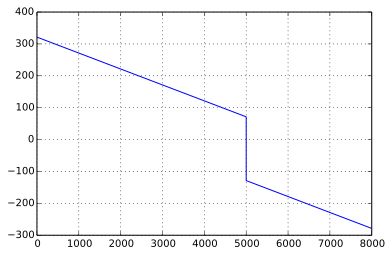

In [23]:
if DEBUG:
    plt.grid(True)
    plt.plot(xv,-v*1e-3)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


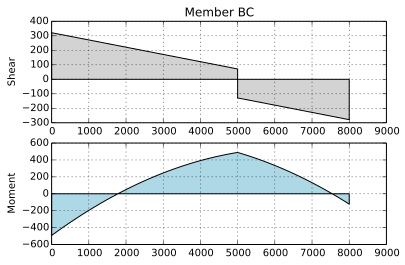

In [24]:
if DEBUG:
    plt.subplot(2,1,1)
    plt.title('Member {}'.format(memb))
    plt.grid(True)
    plt.fill_between(x=xv,y1=-v*1e-3,color='lightgray',edgecolor='black')
    plt.ylabel('Shear')
    plt.subplot(2,1,2)
    plt.grid(True)
    plt.fill_between(xm,m*1e-6,color='lightblue',edgecolor='black')
    plt.ylabel('Moment')